In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [45]:
def simple_model_test(df, stat='ORB'):
    """
    Test simple linear adjustments for rest and home court effects,
    comparing against naive season mean predictions
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import matplotlib.pyplot as plt
    
    # Reshape data
    data = df.copy()
    
    # Calculate team season baselines
    team_seasons = data.groupby(['SEASON', 'TEAM'])[stat].mean().reset_index()
    data = data.merge(team_seasons, 
                     on=['SEASON', 'TEAM'], 
                     suffixes=('', '_baseline'))
    
    print("\n=== Baseline Model (Season Means) ===")
    baseline_error = data[stat] - data[f'{stat}_baseline']
    print(f"RMSE: {np.sqrt(mean_squared_error(data[stat], data[f'{stat}_baseline'])):.2f}")
    print(f"MAE: {mean_absolute_error(data[stat], data[f'{stat}_baseline']):.2f}")
    print(f"Mean Error: {np.mean(baseline_error):.2f}")
    print(f"Error Std: {np.std(baseline_error):.2f}")
    
    # Create design matrix
    X = pd.get_dummies(data['REST'], prefix='rest')
    X['is_home'] = data['IS_HOME']
    
    # Response variable: difference from baseline
    y = data[stat] - data[f'{stat}_baseline']
    
    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    # Print results
    print("\n=== Rest and Home Court Model Results ===")
    print("\nHome Court Effect:")
    print(f"{model.coef_[-1]:.2f} {stat}")
    
    print("\nRest Effects:")
    for i, coef in enumerate(model.coef_[:-1]):
        print(f"Rest {i}: {coef:.2f} {stat}")
    
    # Calculate predictions and errors
    y_pred = model.predict(X)
    adjusted_predictions = data[f'{stat}_baseline'] + y_pred
    
    # Calculate improvement metrics
    print("\n=== Model Comparison ===")
    print("Baseline (Season Means) vs Rest-Adjusted Model:")
    print(f"Baseline RMSE: {np.sqrt(mean_squared_error(data[stat], data[f'{stat}_baseline'])):.2f}")
    print(f"Adjusted RMSE: {np.sqrt(mean_squared_error(data[stat], adjusted_predictions)):.2f}")
    print(f"RMSE Improvement: {np.sqrt(mean_squared_error(data[stat], data[f'{stat}_baseline'])) - np.sqrt(mean_squared_error(data[stat], adjusted_predictions)):.2f}")
    
    print(f"\nBaseline MAE: {mean_absolute_error(data[stat], data[f'{stat}_baseline']):.2f}")
    print(f"Adjusted MAE: {mean_absolute_error(data[stat], adjusted_predictions):.2f}")
    print(f"MAE Improvement: {mean_absolute_error(data[stat], data[f'{stat}_baseline']) - mean_absolute_error(data[stat], adjusted_predictions):.2f}")
    
    # R-squared for both models
    baseline_r2 = 1 - np.sum((data[stat] - data[f'{stat}_baseline'])**2) / np.sum((data[stat] - data[stat].mean())**2)
    adjusted_r2 = 1 - np.sum((data[stat] - adjusted_predictions)**2) / np.sum((data[stat] - data[stat].mean())**2)
    print(f"\nBaseline R-squared: {baseline_r2:.3f}")
    print(f"Adjusted R-squared: {adjusted_r2:.3f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Actual vs Predicted for both models
    axes[0,0].scatter(data[stat], data[f'{stat}_baseline'], 
                     alpha=0.1, label='Baseline')
    axes[0,0].scatter(data[stat], adjusted_predictions, 
                     alpha=0.1, label='Adjusted')
    axes[0,0].plot([data[stat].min(), data[stat].max()], 
                   [data[stat].min(), data[stat].max()], 'r--')
    axes[0,0].set_xlabel('Actual')
    axes[0,0].set_ylabel('Predicted')
    axes[0,0].set_title('Actual vs Predicted Values')
    axes[0,0].legend()
    
    # 2. Rest Effects with Confidence Intervals
    rest_effects = pd.DataFrame({
        'effect': model.coef_[:-1],
        'rest': range(len(model.coef_[:-1]))
    })
    
    # Calculate standard errors
    X_rest = X.iloc[:, :-1]
    residuals = data[stat] - adjusted_predictions
    mse = np.sum(residuals**2) / (len(residuals) - len(model.coef_))
    var_coef = mse * np.linalg.inv(X_rest.T @ X_rest).diagonal()
    rest_effects['se'] = np.sqrt(var_coef)
    
    rest_effects.plot(x='rest', y='effect', 
                     yerr='se', kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Rest Effects with 95% CI')
    axes[0,1].set_xlabel('Rest Days')
    axes[0,1].set_ylabel(f'Effect on {stat}')
    
    # 3. Error Distribution Comparison
    baseline_errors = data[stat] - data[f'{stat}_baseline']
    adjusted_errors = data[stat] - adjusted_predictions
    
    sns.kdeplot(data=baseline_errors, ax=axes[1,0], label='Baseline')
    sns.kdeplot(data=adjusted_errors, ax=axes[1,0], label='Adjusted')
    axes[1,0].set_title('Error Distribution Comparison')
    axes[1,0].set_xlabel('Error')
    axes[1,0].legend()
    
    # 4. QQ Plot of Residuals
    from scipy import stats
    stats.probplot(adjusted_errors, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Normal Q-Q Plot of Adjusted Model Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Additional Diagnostics
    print("\n=== Error Distribution Statistics ===")
    print("Baseline Errors:")
    print(f"Mean: {np.mean(baseline_errors):.2f}")
    print(f"Std: {np.std(baseline_errors):.2f}")
    print(f"Skewness: {stats.skew(baseline_errors):.2f}")
    print(f"Kurtosis: {stats.kurtosis(baseline_errors):.2f}")
    
    print("\nAdjusted Model Errors:")
    print(f"Mean: {np.mean(adjusted_errors):.2f}")
    print(f"Std: {np.std(adjusted_errors):.2f}")
    print(f"Skewness: {stats.skew(adjusted_errors):.2f}")
    print(f"Kurtosis: {stats.kurtosis(adjusted_errors):.2f}")
    
    results = {
        'model': model,
        'coefficients': dict(zip(X.columns, model.coef_)),
        'baseline_rmse': np.sqrt(mean_squared_error(data[stat], data[f'{stat}_baseline'])),
        'adjusted_rmse': np.sqrt(mean_squared_error(data[stat], adjusted_predictions)),
        'baseline_r2': baseline_r2,
        'adjusted_r2': adjusted_r2,
        'baseline_errors': baseline_errors,
        'adjusted_errors': adjusted_errors
    }
    
    return results

# Usage:
# results = simple_model_test(df, 'PTS')

In [52]:
df = pd.read_csv('data/game/box_raw/reshaped_regular_season_games.csv')
df = df[df['SEASON'] == '2023-24']


=== Baseline Model (Season Means) ===
RMSE: 12.15
MAE: 9.76
Mean Error: -0.00
Error Std: 12.15

=== Rest and Home Court Model Results ===

Home Court Effect:
2.17 PTS

Rest Effects:
Rest 0: -0.22 PTS
Rest 1: -1.94 PTS
Rest 2: -1.14 PTS

=== Model Comparison ===
Baseline (Season Means) vs Rest-Adjusted Model:
Baseline RMSE: 12.15
Adjusted RMSE: 12.09
RMSE Improvement: 0.06

Baseline MAE: 9.76
Adjusted MAE: 9.75
MAE Improvement: 0.01

Baseline R-squared: 0.105
Adjusted R-squared: 0.114


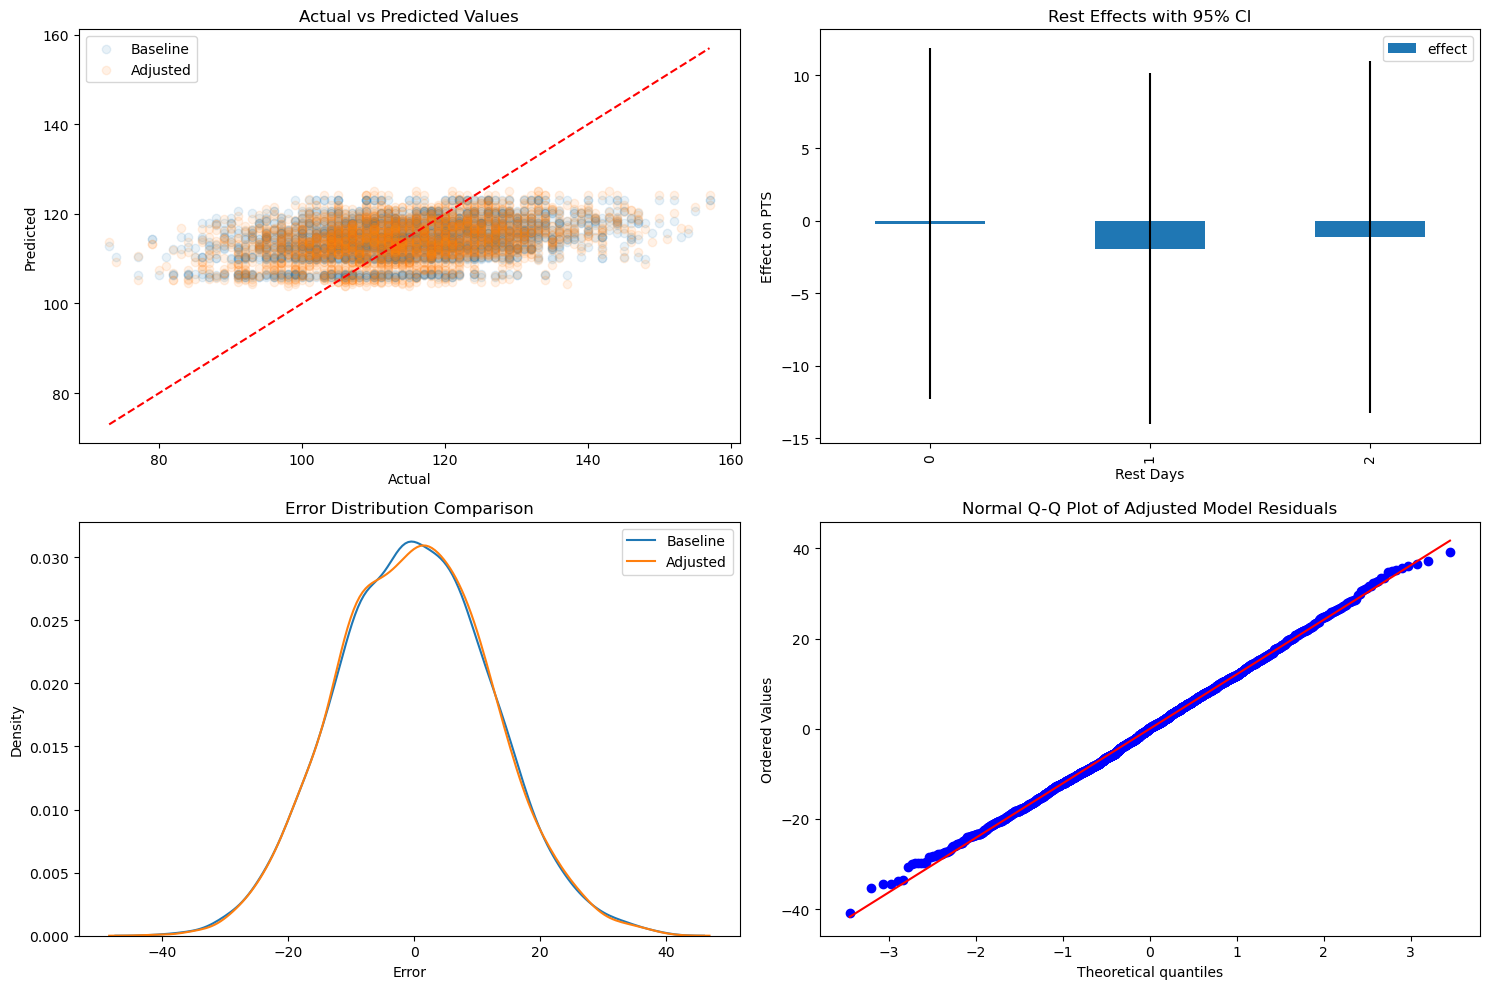


=== Error Distribution Statistics ===
Baseline Errors:
Mean: -0.00
Std: 12.15
Skewness: 0.07
Kurtosis: -0.11

Adjusted Model Errors:
Mean: -0.00
Std: 12.09
Skewness: 0.07
Kurtosis: -0.14


{'model': LinearRegression(fit_intercept=False),
 'coefficients': {'rest_1in3': -0.21628580528097147,
  'rest_2in2': -1.9376214771997167,
  'rest_2in3': -1.135450609834253,
  'is_home': 2.16708584805586},
 'baseline_rmse': 12.147066493110934,
 'adjusted_rmse': 12.086045162137312,
 'baseline_r2': 0.10474482147465425,
 'adjusted_r2': 0.11371693755071965,
 'baseline_errors': 0      -11.000000
 1        4.146341
 2       -8.243902
 3      -13.481928
 4        4.634146
           ...    
 2469    -6.095238
 2470   -21.238095
 2471     1.904762
 2472   -18.357143
 2473    -9.845238
 Length: 2474, dtype: float64,
 'adjusted_errors': 0      -10.783714
 1        2.195541
 2       -8.027617
 3      -15.432728
 4        4.850432
           ...    
 2469    -5.878952
 2470   -20.102645
 2471     0.873127
 2472   -18.140857
 2473   -11.796038
 Length: 2474, dtype: float64}

In [54]:
simple_model_test(df, stat='PTS')